  # Training a Neural Network to Recognize Digits

  ## Import Dependencies

In [1]:
import os

import numpy as np
import pandas as pd

import digits as dg
import net as nn

  ## Loading Digits from Files

In [2]:
DATA_PATH = os.path.join('..', 'data', 'cache')

allDigits = dg.getDigits()
trainDigits = dg.getDigits(
    kinds={'normal', 'normal-klein', 'digital', 'digital-klein'})
testDigits = dg.getDigits(kinds={'evag'})

DIGITS = {
    'all': dg.extractInputAndOutput(allDigits),
    'training': dg.extractInputAndOutput(trainDigits),
    'test': dg.extractInputAndOutput(testDigits),
}

  ## Initialize Networks with Different Number of Hidden Neurons

In [3]:
# This calculation might take a while.
# See below, how to load the results from cache instead

# parameters
numOfHiddens = {5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90}
numOfNets = 100

input = DIGITS['all']['input']
output = DIGITS['all']['output']

initNets = {
    'net': [],
    'numOfHidden': [],
    'error': [],
}

for numOfHidden in numOfHiddens:  # generate nets for each number of hidden neurons
    # seed the random number generator to create reproduceable results
    np.random.seed(0)

    for _ in range(numOfNets):  # generate several nets of the same topology
        net = nn.init(35, numOfHidden, 10)
        error = nn.calcBatchError(net, input, output)

        initNets['net'].append(net)
        initNets['numOfHidden'].append(numOfHidden)
        initNets['error'].append(error)

INIT_NETS = pd.DataFrame(initNets)

In [4]:
# store initial networks to cache
INIT_NETS.to_pickle(os.path.join(DATA_PATH, 'init-nets.pkl'))

In [5]:
# load initial networks from cache
INIT_NETS = pd.read_pickle(os.path.join(DATA_PATH, 'init-nets.pkl'))

<AxesSubplot:title={'center':'Error to Number of Hidden Neurons'}, xlabel='numOfHidden', ylabel='error'>

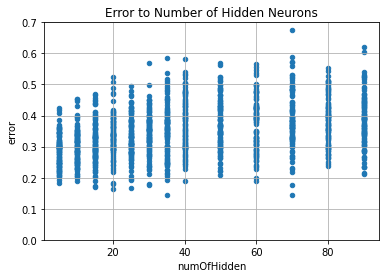

In [6]:
# show error values for the initial networks by topology
INIT_NETS.plot.scatter(
    'numOfHidden', 'error',
    title='Error to Number of Hidden Neurons',
    ylim=(0, 0.7), grid=True,
)

In [7]:
# show nets with smallest error value
INIT_NETS.groupby('numOfHidden').min('error').sort_values('error')

,error
numOfHidden,
35,0.143571
70,0.143792
20,0.162996
25,0.166742
15,0.170721
30,0.176098
5,0.183089
10,0.187878
60,0.188517


  ## Training Promising Networks

In [8]:
# This calculation might take a while.
# See below, how to load the results from cache instead

# parameters
numOfHiddens = {35, 70, 20, 25, 15, 30}
epoches = 1000
learnRate = 0.1

inputTrain = DIGITS['training']['input']
outputTrain = DIGITS['training']['output']

inputTest = DIGITS['test']['input']
outputTest = DIGITS['test']['output']

trainHistory = {
    'net': [],
    'numOfHidden': [],
    'errorTrain': [],
    'errorTest': [],
}

for numOfHidden in numOfHiddens:  # do training for all promising nets
    net = INIT_NETS[INIT_NETS.numOfHidden == numOfHidden].sort_values(
        'error').iloc[0].net

    for i in range(epoches):  # train for several epochs
        net = nn.trainBatch(net, inputTrain, outputTrain, learnRate)
        errorTrain = nn.calcBatchError(net, inputTrain, outputTrain)
        errorTest = nn.calcBatchError(net, inputTest, outputTest)

        trainHistory['net'].append(net)
        trainHistory['numOfHidden'].append(numOfHidden)
        trainHistory['errorTrain'].append(errorTrain)
        trainHistory['errorTest'].append(errorTest)

TRAIN_HIDDEN = pd.DataFrame(trainHistory)

In [9]:
# store trained promising networks to cache
TRAIN_HIDDEN.to_pickle(os.path.join(DATA_PATH, 'train-hidden.pkl'))

In [10]:
# load trained promising networks from cache
TRAIN_HIDDEN = pd.read_pickle(os.path.join(DATA_PATH, 'train-hidden.pkl'))

In [11]:
# calculate which net's error was reduced the most
end = TRAIN_HIDDEN.groupby('numOfHidden').min(
    'errorTrain').sort_values('numOfHidden')
start = INIT_NETS.groupby('numOfHidden').min(
    'error').sort_values('numOfHidden')

diff = end.join(start)
diff.rename(columns={'error': 'errorStart'}, inplace=True)
diff['diff'] = diff.errorStart - diff.errorTrain

diff.sort_values('diff', ascending=False)

,errorTrain,errorTest,errorStart,diff
numOfHidden,,,,
30,0.086010,0.091076,0.176098,0.090088
15,0.086051,0.086862,0.170721,0.084670
25,0.089231,0.086783,0.166742,0.077511
20,0.091201,0.089823,0.162996,0.071795
35,0.084060,0.086994,0.143571,0.059512
70,0.088598,0.091938,0.143792,0.055195


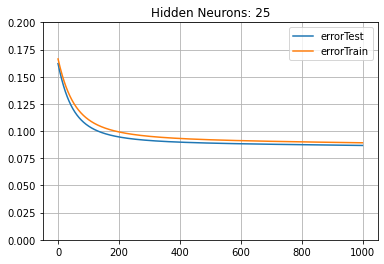

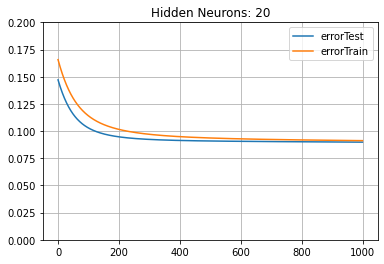

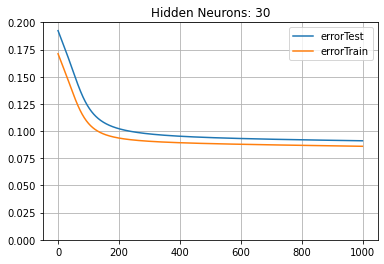

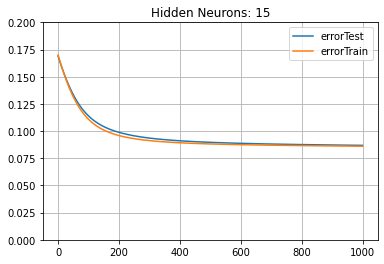

In [12]:
# show the development of error values during training
for numOfHidden in {15, 20, 25, 30}:
    TRAIN_HIDDEN[TRAIN_HIDDEN.numOfHidden == numOfHidden].plot.line(
        title=f'Hidden Neurons: {numOfHidden}',
        y={'errorTrain', 'errorTest'}, ylim=(0, 0.2),
        use_index=False, grid=True,
    )

  ## Finding the Optimal Learning Rate

In [13]:
# This calculation might take a while.
# See below, how to load the results from cache instead

# parameters
numOfHidden = 15
learnRates = {1, 0.1, 0.01, 0.001}
epoches = 10000

startNet = INIT_NETS[INIT_NETS.numOfHidden == numOfHidden].sort_values(
    'error').iloc[0].net

inputTrain = DIGITS['training']['input']
outputTrain = DIGITS['training']['output']

inputTest = DIGITS['test']['input']
outputTest = DIGITS['test']['output']

trainHistory = {
    'net': [],
    'learnRate': [],
    'errorTrain': [],
    'errorTest': [],
}

for learnRate in learnRates:  # do training for all learning rates
    net = startNet

    for i in range(epoches):  # do training for several epochs
        net = nn.trainBatch(net, inputTrain, outputTrain, learnRate)
        errorTrain = nn.calcBatchError(net, inputTrain, outputTrain)
        errorTest = nn.calcBatchError(net, inputTest, outputTest)

        trainHistory['net'].append(net)
        trainHistory['learnRate'].append(learnRate)
        trainHistory['errorTrain'].append(errorTrain)
        trainHistory['errorTest'].append(errorTest)

TRAIN_LR = pd.DataFrame(trainHistory)

In [14]:
# store training with different learning rates to cache
TRAIN_LR.to_pickle(os.path.join(DATA_PATH, 'train-learn-rate.pkl'))

In [15]:
# load training with different learning rates from cache
TRAIN_LR = pd.read_pickle(os.path.join(DATA_PATH, 'train-learn-rate.pkl'))

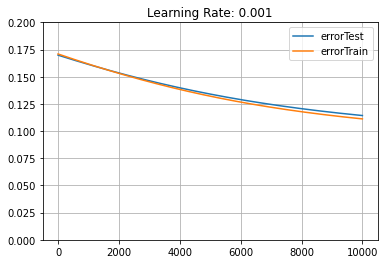

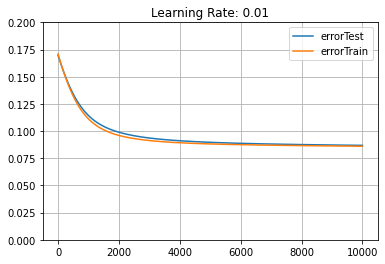

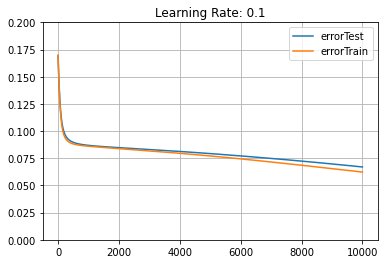

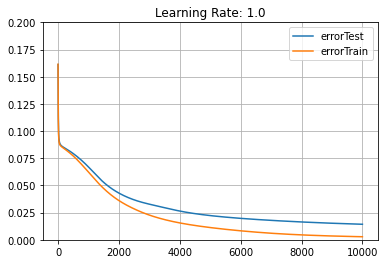

In [16]:
# show development of error during training for different learning rates
for learnRate, df in TRAIN_LR.groupby('learnRate'):
    df.plot.line(
        title=f'Learning Rate: {learnRate}',
        y={'errorTrain', 'errorTest'}, ylim=(0, 0.2),
        use_index=False, grid=True,
    )

In [17]:
# show how high the remaining error values ares
TRAIN_LR.groupby('learnRate').min('errorTrain').sort_values('errorTrain')

,errorTrain,errorTest
learnRate,,
1.000,0.002821,0.014294
0.100,0.062284,0.066992
0.010,0.086051,0.086864
0.001,0.111204,0.114295


  ## Final Training of the Network

In [18]:
# This calculation might take a while.
# See below, how to load the results from cache instead

# parameters
learnRate = 1
targetError = 0.001

inputTrain = DIGITS['training']['input']
outputTrain = DIGITS['training']['output']

inputTest = DIGITS['test']['input']
outputTest = DIGITS['test']['output']

# reuse all the training steps from before, when learning rate was determined
trainHistory = TRAIN_LR[TRAIN_LR.learnRate == learnRate].drop('learnRate', 1)
net = trainHistory.iloc[-1].net
error = nn.calcBatchError(net, inputTrain, outputTrain)

while error > targetError:  # train as long as the error is too high
    net = nn.trainBatch(net, inputTrain, outputTrain, learnRate)
    errorTrain = nn.calcBatchError(net, inputTrain, outputTrain)
    errorTest = nn.calcBatchError(net, inputTest, outputTest)

    trainHistory = trainHistory.append({
        'net': net,
        'errorTrain': errorTrain,
        'errorTest': errorTest,
    }, ignore_index=True)

    error = errorTrain

TRAIN_FINAL = trainHistory

In [19]:
# store final training round to cache
TRAIN_FINAL.to_pickle(os.path.join(DATA_PATH, 'train-final.pkl'))

In [20]:
# load final training round from cache
TRAIN_FINAL = pd.read_pickle(os.path.join(DATA_PATH, 'train-final.pkl'))

<AxesSubplot:title={'center':'Error During Final Training'}>

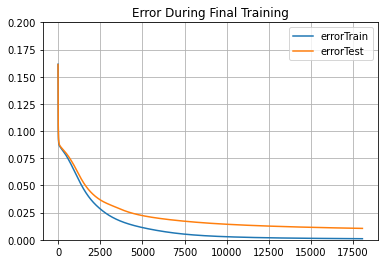

In [21]:
# show the development of the error during training the final network
TRAIN_FINAL.plot.line(
    title='Error During Final Training',
    ylim=(0, 0.2), grid=True,
)

In [22]:
# show how many epochs there were in the end
TRAIN_FINAL.describe()

,errorTrain,errorTest
count,18052.000000,18052.000000
mean,0.012627,0.022609
std,0.019830,0.017714
min,0.001000,0.010490
25%,0.001604,0.012087
50%,0.003481,0.015205
75%,0.013109,0.024004
max,0.161496,0.161170


  ## Analyzing the Final Neural Network

In [23]:
FINAL_NET = TRAIN_FINAL.iloc[-1].net

In [24]:
# store final network to cache
nn.save(FINAL_NET, os.path.join(DATA_PATH, 'final-net.pkl'))

In [25]:
# load final network from cache
FINAL_NET = nn.load(os.path.join(DATA_PATH, 'final-net.pkl'))

<AxesSubplot:title={'center':'Average Error per Set'}, xlabel='kind'>

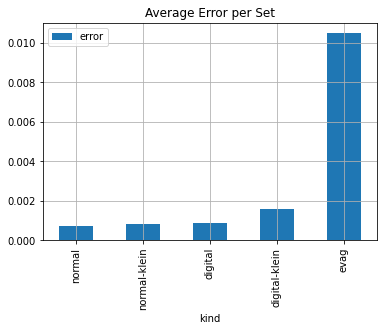

In [26]:
# show the average error per digit set

net = FINAL_NET
result = {
    'kind': [],
    'error': [],
}

for kind in dg.ALL_KINDS:
    digits = dg.getDigits(kinds={kind})
    inOutputs = dg.extractInputAndOutput(digits)
    error = nn.calcBatchError(net, inOutputs['input'], inOutputs['output'])

    result['kind'].append(kind)
    result['error'].append(error)

pd.DataFrame(result).sort_values('error').plot.bar(
    x='kind', title='Average Error per Set',
    grid=True, ylim=(0, 0.011),
)

<AxesSubplot:title={'center':'Average Error per Digit'}, xlabel='digit'>

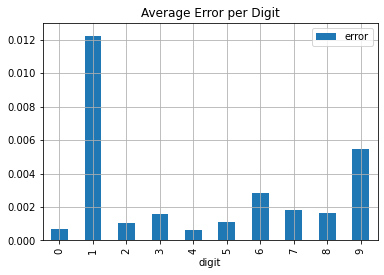

In [27]:
# show the average error per digit (over all sets)

net = FINAL_NET
result = {
    'digit': [],
    'error': [],
}

for digit in dg.ALL_DIGITS:
    digits = dg.getDigits(digits={digit})
    inOutputs = dg.extractInputAndOutput(digits)
    error = nn.calcBatchError(net, inOutputs['input'], inOutputs['output'])

    result['digit'].append(digit)
    result['error'].append(error)

pd.DataFrame(result).plot.bar(
    x='digit', title='Average Error per Digit',
    grid=True,  ylim=(0, 0.013),
)

<AxesSubplot:title={'center':'Average Error on evag Set per Digit'}, xlabel='digit'>

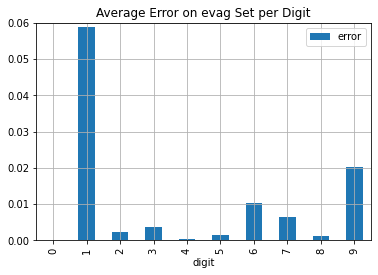

In [28]:
# show the average error per digit for the test data

net = FINAL_NET
result = {
    'digit': [],
    'error': [],
}

for digit in dg.ALL_DIGITS:
    digits = dg.getDigits(digits={digit}, kinds={'evag'})
    inOutputs = dg.extractInputAndOutput(digits)
    error = nn.calcBatchError(net, inOutputs['input'], inOutputs['output'])

    result['digit'].append(digit)
    result['error'].append(error)

pd.DataFrame(result).plot.bar(
    x='digit', title='Average Error on evag Set per Digit',
    grid=True,  ylim=(0, 0.06),
)

<AxesSubplot:title={'center':'Average Error on Training Set per Digit'}, xlabel='digit'>

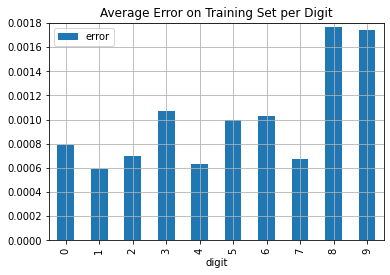

In [29]:
# show the average error per digit for the training data

net = FINAL_NET
result = {
    'digit': [],
    'error': [],
}

for digit in dg.ALL_DIGITS:
    digits = dg.getDigits(digits={digit}, kinds={
                          'normal', 'normal-klein', 'digital', 'digital-klein'})
    inOutputs = dg.extractInputAndOutput(digits)
    error = nn.calcBatchError(net, inOutputs['input'], inOutputs['output'])

    result['digit'].append(digit)
    result['error'].append(error)

pd.DataFrame(result).plot.bar(
    x='digit', title='Average Error on Training Set per Digit',
    grid=True,  ylim=(0, 0.0018),
)